In [1]:
import fastbook 
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.all import *

In [3]:
df=pd.read_csv("F:/Deep Learning/FastAI/Datasets/fairface/FairFace/train_labels.csv")

In [4]:
df.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [5]:
dblock=DataBlock()

In [6]:
dsets=dblock.datasets(df)

In [7]:
len(dsets.train),len(dsets.valid)

(69396, 17348)

In [8]:
x,y=dsets.train[0]
x,y

(file            train/84711.jpg
 age                         3-9
 gender                     Male
 race            Southeast Asian
 service_test              False
 Name: 84710, dtype: object,
 file            train/84711.jpg
 age                         3-9
 gender                     Male
 race            Southeast Asian
 service_test              False
 Name: 84710, dtype: object)

In [9]:
x['file']

'train/84711.jpg'

In [10]:
dblocks=DataBlock(get_x=lambda r: r['file'],get_y=lambda r: r['race'])
dsets=dblock.datasets(df)
dsets.train[0]

(file            train/37467.jpg
 age                       40-49
 gender                     Male
 race                      Black
 service_test              False
 Name: 37466, dtype: object,
 file            train/37467.jpg
 age                       40-49
 gender                     Male
 race                      Black
 service_test              False
 Name: 37466, dtype: object)

In [11]:
def get_x(r): return r['file']
def get_y(r): return r['race'],r['gender'],r['age'],r['service_test']
dblock=DataBlock(get_x=get_x,get_y=get_y)
dsets=dblock.datasets(df)
dsets.train[0]

('train/53825.jpg', ('White', 'Female', '40-49', False))

In [12]:
path=Path()
def get_x(r): return path/'Datasets'/'fairface'/'FairFace'/r['file']
# def get_y(r): return r[['race','gender','age','service_test']].split(' ')
# def get_y(r):
#     r=r.drop(columns='file')
#     r=list(r)
#     return r
def get_y(r): return r['race']
dblock=DataBlock(get_x=get_x,get_y=get_y)
dsets=dblock.datasets(df)
dsets.train[0]

(Path('Datasets/fairface/FairFace/train/13151.jpg'), 'East Asian')

In [13]:
dblock=DataBlock(blocks=(ImageBlock,CategoryBlock),
                get_x=get_x,get_y=get_y)
dsets=dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=224x224, TensorCategory(5))

In [14]:
idxs=torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#0) []

In [15]:
def splitter(df):
    train=df.index[~df['service_test']].tolist()
    valid=df.index[~df['service_test']].tolist()
    return train,valid
dblock=DataBlock(blocks=(ImageBlock,CategoryBlock),
                splitter=splitter,
                get_x=get_x,get_y=get_y)
dsets=dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=224x224, TensorCategory(2))

In [16]:
dblock=DataBlock(blocks=(ImageBlock,CategoryBlock),
                splitter=splitter,
                get_x=get_x,get_y=get_y,
                item_tfms=RandomResizedCrop(128,min_scale=0.35))
dls=dblock.dataloaders(df)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


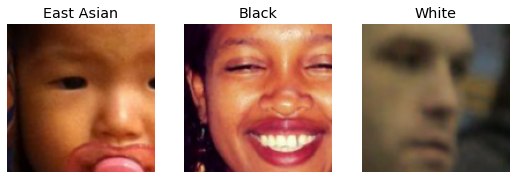

In [17]:
dls.show_batch(nrows=1,ncols=3)

In [18]:
def get_data(presize,resize):
    return DataBlock(
    blocks=(ImageBlock,CategoryBlock),get_x=get_x,get_y=get_y,
    splitter=splitter,item_tfms=Resize(presize),
    batch_tfms=[*aug_transforms(min_scale=0.5,size=resize),
               Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(df,bs=128)

In [19]:
dls=get_data(160,128)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Users\mayan\anaconda3\envs\GPU\lib\site-packages\torch\_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


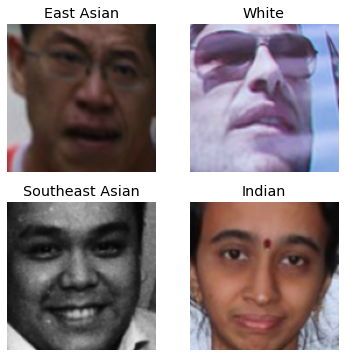

In [20]:
dls.show_batch(max_n=4)

In [21]:
def block(ni,nf): return ConvLayer(ni,nf,stride=2)
def get_model():
    return nn.Sequential(
    block(3,16),
    block(16,32),
    block(32,64),
    block(64,128),
    block(128,256),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(256,dls.c))

In [22]:
def get_learner(m):
    return Learner(dls,m,loss_func=nn.CrossEntropyLoss(),metrics=accuracy)
learn=get_learner(get_model())

SuggestedLRs(valley=0.0014454397605732083)

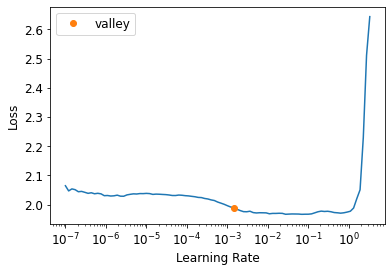

In [23]:
learn.lr_find()

In [24]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [ ]:
img=PILImage.create(image_cat())
x,=first(dls.test_dl([img]))

In [ ]:
class Hook():
    def hook_func(self,m,i,o): self.stored=o.detach().clone()

In [ ]:
hook_output=Hook()
hook=learn.model[0].register_forward_hook(hook_output.hook_func)

In [ ]:
with torch.no_grad(): output=learn.model.eval()(x)

In [ ]:
act=hook_output.stored[0]

In [ ]:
F.softmax(output,dim=-1)

In [ ]:
dls.vocab

In [ ]:
class ResBlock(Module):
    def __init__(self,ni,nf):
        self.convs=nn.Sequential(
        ConvLayer(ni,nf),
        ConvLayer(nf,nf,norm_type=NormType.BatchZero))
    def forward(self,x): return x+self.convs(x)

In [ ]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
    ConvLayer(ni,nf,stride=stride),
    ConvLayer(nf,nf,act_cls=None,norm_type=NormType.BatchZero))

In [ ]:
class ResBlock(Module):
    def __init__(self,ni,nf,stride=1):
        self.convs= _conv_block(ni,nf,stride)
        self.idconv=noop if ni==nf else ConvLayer(ni,nf,1,act_cls=None)
        self.pool=noop if stride==1 else nn.AvgPool2d(2,ceil_mode=True)
    def forward(self,x):
        return F.relu(self.convs(x)+self.idconv(self.pool(x)))

In [ ]:
def block(ni,nf): return ResBlock(ni,nf,stride=2)
learn=get_learner(get_model())

In [ ]:
learn.fit_one_cycle(5,3e-3)

In [25]:
path = untar_data(URLs.PETS)/'images'
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,error_rate,time
0,0.131567,0.022922,0.010149,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.054127,0.020933,0.006766,01:03
